In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('talk')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as OUTPUT_DIRECTORY_MAIN

OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY_MAIN, 'preprocessing')
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

In [3]:
from snapanalysis.preprocessing.cleanup.main import OUTPUT_FILE as ENRICHMENT_MODEL_INPUT
from snapanalysis.models.enrichment.generate import RATIO_COLUMN
from snapanalysis.models.enrichment.generate import rotate, EnrichmentDecoposition
from snapanalysis.models.enrichment.generate import OUTPUT_FILE as ENRICHMENT_OUTPUT

from snapanalysis.visualisation.heatmaps.pattern_heatmap import PULLDOWN_ORDER


In [4]:
enrichment_data = pd.read_hdf(ENRICHMENT_OUTPUT, 'enrichment_data')

In [5]:
all_zero = (enrichment_data[['Ratio H/L normalized (log2) (adjusted, imputed, forward)', 
                             'Ratio H/L normalized (log2) (adjusted, imputed, reverse)']] == 0).all(axis=1)

n_zero = (all_zero).groupby(level='Gene label').sum()


In [6]:
not_all_zero = n_zero[n_zero < 55].index

enrichment_data = enrichment_data.loc[not_all_zero]
n_zero = n_zero.loc[not_all_zero]
# imputation_data = imputation_data.loc[n_non_zero]

In [7]:
n_pulldowns = enrichment_data.reset_index()['Pull-Down ID'].nunique()
n_proteins = enrichment_data.reset_index()['Gene label'].nunique()

In [8]:
n_zero_counts = n_zero.value_counts()
n_zero_counts.index.name = 'n_zero'
n_zero_counts.value = 'n_proteins'

n_zero_counts = n_zero_counts.reindex(range(0, n_pulldowns))
n_zero_counts_cumsum = n_zero_counts.cumsum()

In [9]:
imputation_data = enrichment_data['Imputation type']
n_imputed = imputation_data.unstack('Pull-Down ID')
n_imputed = (~n_imputed.isnull()).sum(axis=1)

In [10]:
imputation_counts = imputation_data.copy().fillna('Not imputed')
imputation_counts = imputation_counts.replace('zero-fill', 'Zero')
imputation_counts = imputation_counts.replace('ratio projection', 'Other ratio')
imputation_counts = imputation_counts.replace('max enrichment', 'Maximum')

imputation_counts = imputation_counts.value_counts()

imputation_ratios = imputation_counts / imputation_counts.sum()

In [11]:
imputation_order = ['Not imputed', 'Zero', 'Other ratio', 'Maximum']
imputation_palette = {
    'Not imputed': sns.desaturate('#1E1E1E', 0.9),
    'Zero': sns.desaturate('#BB3524', 0.9),
    'Other ratio': sns.desaturate('#F5D54B', 0.9),
    'Maximum': sns.desaturate('#394827', 0.9)
}
assert all([x in imputation_order for x in imputation_ratios.index])

In [12]:
imputation_ratios.index

Index(['Not imputed', 'Zero', 'Other ratio', 'Maximum'], dtype='object')

In [13]:
import matplotlib.ticker as ticker


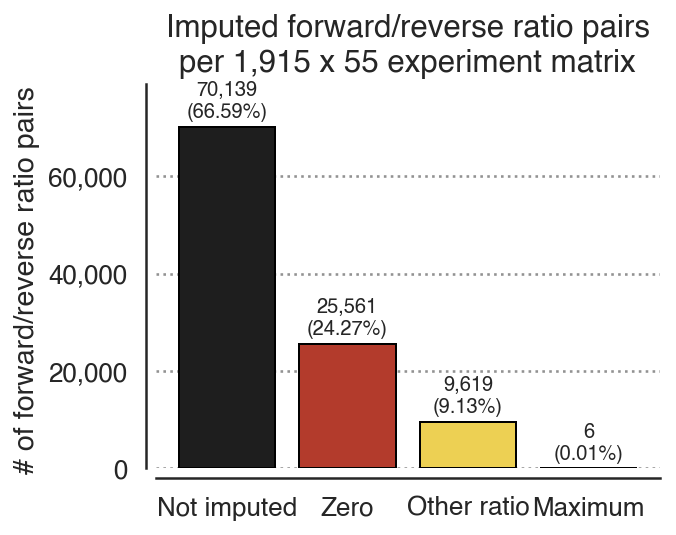

In [18]:
fig = plt.figure(figsize=(5, 4))
ax = plt.gca()

xx = imputation_order
yy = imputation_counts.loc[xx]
colors = [imputation_palette[x] for x in imputation_order]

ax.bar(xx, yy, edgecolor='black', linewidth=1.0, color=colors)

for x in imputation_order:
    y = imputation_counts.loc[x]
    pct = imputation_ratios.loc[x]
    
    text = f'{y:,}\n({pct:.2%})'
    
    ax.text(x, y + 1000, 
            text, 
            fontsize=10,
            ha='center', 
            va='bottom')


ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)
ax.set_ylabel(f'# of forward/reverse ratio pairs ')
ax.set_title(f'Imputed forward/reverse ratio pairs\nper {n_proteins:,} x {n_pulldowns:,} experiment matrix')
ax.set_ylim(0, 79000)
ax.xaxis.grid(False)
sns.despine(ax=ax, offset=5)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'imputation-statistics.pdf'), bbox_inches='tight')

In [19]:
n_imputed_counts = n_imputed.value_counts()
n_imputed_counts.index.name = 'n_imputed_values'
n_imputed_counts.value = 'n_proteins'

n_imputed_counts = n_imputed_counts.reindex(range(0, n_pulldowns))

n_imputed_counts_cumsum = n_imputed_counts.cumsum()

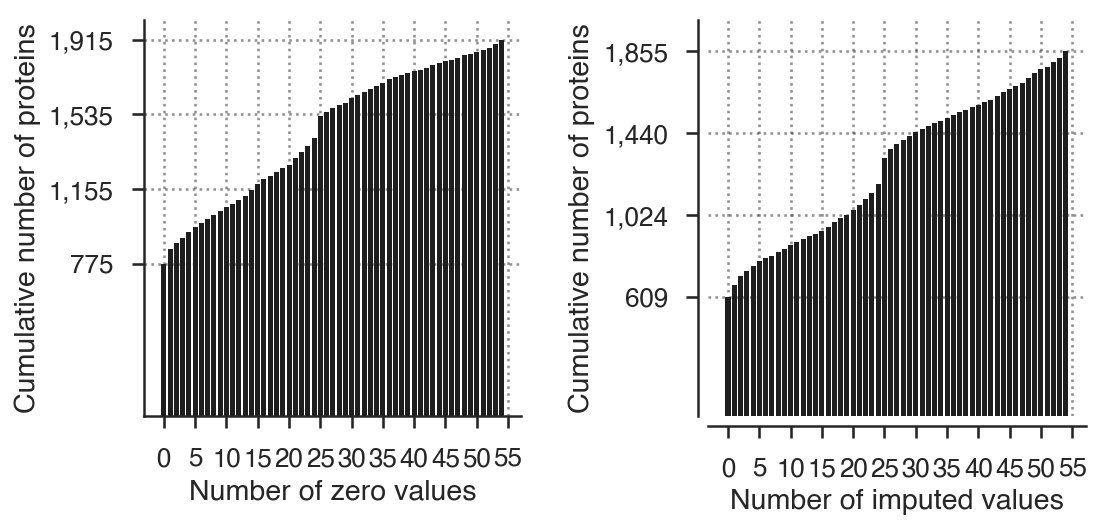

In [20]:
fig = plt.figure(figsize=(8, 4))

color_barplot = color=sns.desaturate('#1E1E1E', 0.9)

ax_n_imputed = plt.subplot(1, 2, 2)
ax_n_nonzero = plt.subplot(1, 2, 1)


ax_n_imputed.bar(n_imputed_counts_cumsum.index, n_imputed_counts_cumsum,
                 color=color_barplot)
ax_n_imputed.set_xlabel('Number of imputed values')

ax_n_nonzero.bar(n_zero_counts_cumsum.index, 
                 n_zero_counts_cumsum,
                 color=color_barplot)

ax_n_nonzero.set_xlabel('Number of zero values')

ax_n_imputed.set_xticks(np.arange(0, 56, 5, dtype=int))
ax_n_nonzero.set_xticks(np.arange(0, 56, 5, dtype=int))


ax_n_imputed.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax_n_nonzero.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax_n_imputed.set_ylabel('Cumulative number of proteins')
ax_n_nonzero.set_ylabel('Cumulative number of proteins')

ax_n_imputed.set_ylim(0, n_proteins + 100)
ax_n_nonzero.set_ylim(0, n_proteins + 100)

sns.despine(ax=ax_n_imputed, offset=5)

ax_n_imputed.set_yticks(
    np.linspace(n_imputed_counts_cumsum.loc[0], n_imputed_counts_cumsum.loc[54], 4)
)

ax_n_nonzero.set_yticks(
    np.linspace(n_zero_counts_cumsum.loc[0], n_zero_counts_cumsum.loc[54], 4)
)

plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'figure_imputed_nonzero_cumsum.pdf'), bbox_inches='tight')